In [ ]:
import random as rnd
import os
import numpy as nmpy
import matplotlib.pyplot as pplot
import torch as trch
import torchvision
import torch.nn as neuraln
import torch.optim as toptim
import torch.nn.functional as Func
from PIL import Image
from torch.utils.data import Dataset as TourchDataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms as transf, models, datasets

# Initital configurations
REPREOD_SEED = 1234

def set_seeds(seedarg=1234):
    """Set the seed value for reproducibility."""
    nmpy.random.seed(seedarg)
    rnd.seed(seedarg)
    trch.manual_seed(seedarg)
    trch.cuda.manual_seed(seedarg)
    trch.cuda.manual_seed_all(seedarg)
set_seeds(REPREOD_SEED)
cuda = True
devc = trch.device('cuda' if (
    trch.cuda.is_available() and cuda) else 'cpu'
)

In [ ]:
!pip install torchmetrics

In [ ]:
# Setting up kaggle credentials
# ! Please upload kaggle.json file before running this script

!pip install -q kaggle  # installing the kaggle package
!mkdir -p ~/.kaggle     # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/  # move the key to the folder
!chmod 600 ~/.kaggle/kaggle.json  # change the permissions of the file.

In [ ]:
# Downloading dataset
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# unzipping and removing zip file
!unzip tuberculosis-tb-chest-xray-dataset.zip
!rm -rf tuberculosis-tb-chest-xray-dataset.zip

 99% 660M/663M [00:09<00:00, 66.6MB/s]
100% 663M/663M [00:09<00:00, 77.0MB/s]
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png

In [ ]:
# Preparing dataset folder and moving the files to it.

!mkdir datasets
!cp -r TB_Chest_Radiography_Database/Normal datasets/normal
!cp -r TB_Chest_Radiography_Database/Tuberculosis datasets/tuberculosis
!cp -r TB_Chest_Radiography_Database/Normal.metadata.xlsx datasets/normal.xlsx
!cp -r TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx datasets/tuberculosis.xlsx

!rm -rf TB_Chest_Radiography_Database

mkdir: cannot create directory ‘datasets’: File exists


In [ ]:
"""
Here, we have logically divided the datasets into train, valid and test set in 70:15:15
ratio.
And also we have shuffled the dataset, so that both of the categories images gets mixed
up.
"""
import glob
normal = glob.glob("datasets/normal/*")
tb = glob.glob("datasets/tuberculosis/*")
print("-------------------Dataset------------------")
print("Total Normal CXR Images: ", len(normal))
print("Total Tuberculosis CXR Images: ", len(tb), end='\n\n')
# Split in 70:15:15 ratio
training_path = normal[:2450] + tb[:490]
value_path = normal[2450:2975] + tb[490:595]
testing_path = normal[2975:] + tb[595:]
rnd.shuffle(training_path)
rnd.shuffle(value_path)
rnd.shuffle(testing_path)
print("Total train CXR Images: ", len(training_path))
print("Total val CXR Images: ", len(value_path))
print("Total test CXR Images: ", len(testing_path))

-------------------Dataset------------------
Total Normal CXR Images:  3501
Total Tuberculosis CXR Images:  701

Total train CXR Images:  2940
Total val CXR Images:  630
Total test CXR Images:  632


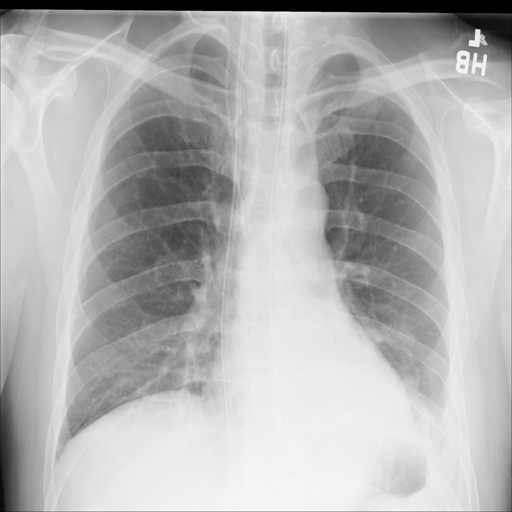

In [ ]:
Image.open(training_path[0])

### Preprocessing
In this step, we defined the data preprocessing pipeline for our dataset. We used the PyTorch library's transforms module to perform a series of image transformations on the dataset.

The images are preprocessed by resizing, random rotation, flipping, center cropping, converting to tensors and normalizing using the mean and standard deviation of the dataset. These steps are performed to ensure that all the images are in the same size and format, ready to be input to the model.

In [ ]:
data_trans = {
    'training': transf.Compose([
        transf.Resize(256),
        transf.RandomRotation(degrees=15),
        transf.RandomHorizontalFlip(),
        transf.CenterCrop(size=224),
        transf.ToTensor(),
        transf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'non-training': transf.Compose([
        transf.Resize(256),
        transf.CenterCrop(224),
        transf.ToTensor(),
        transf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
class TB_CXR_Data_set(TourchDataset):
    def __init__(self, images, transf=None):
        self.image_paths = images
        self.image_labels = [0 if 'normal' in img else 1 for img in self.image_paths]
        self.transf = transf

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.image_labels[index]
        fimage = Image.open(image_path)
        fimage = fimage.convert('RGB')
        if self.transf:
            fimage = self.transf(fimage)
        return fimage, label

train_data = TB_CXR_Data_set(training_path, transf=data_trans['training'])
valid_data = TB_CXR_Data_set(value_path, transf=data_trans['non-training'])
test_data = TB_CXR_Data_set(testing_path, transf=data_trans['non-training'])
trn_dataloader = DataLoader(train_data, 32, True)
vld_dataloader = DataLoader(valid_data, 32, True)
test_dataloader = DataLoader(test_data, 32, True)

## Data Visualization

In this section, we visualized the distribution of our dataset by plotting a bar graph for , as well as visualizing some images from the dataloader to ensure that they were properly loaded and transformed.

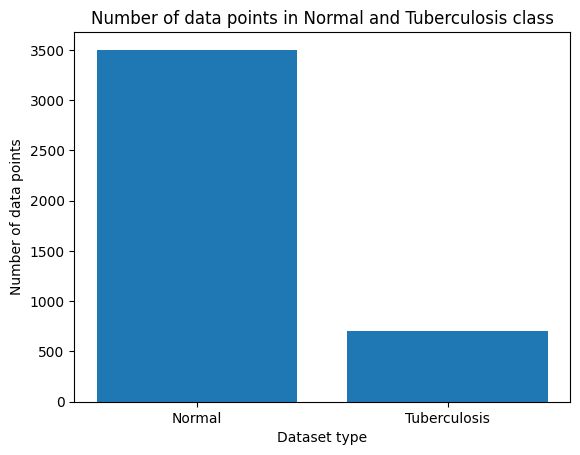

In [ ]:
import matplotlib.pyplot as plt
normal_size = len(normal)
Tuberculosis_size = len(tb)
sizes = [normal_size, Tuberculosis_size]

plt.bar(['Normal', 'Tuberculosis'], sizes)

plt.xlabel('Dataset type')
plt.ylabel('Number of data points')
plt.title('Number of data points in Normal and Tuberculosis class')

plt.show()

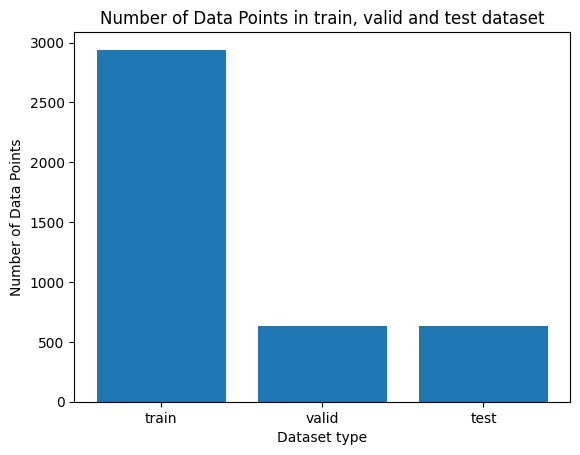

In [ ]:
# Get the number of data points in each dataset
train_size = len(train_data)
valid_size = len(valid_data)
test_size = len(test_data)

# Create a list of the sizes of each dataset
sizes = [train_size, valid_size, test_size]

# Create a bar plot with the sizes of the datasets
plt.bar(['train', 'valid', 'test'], sizes)

# Add labels and title to the plot
plt.xlabel('Dataset type')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in train, valid and test dataset')

# Show the plot
plt.show()


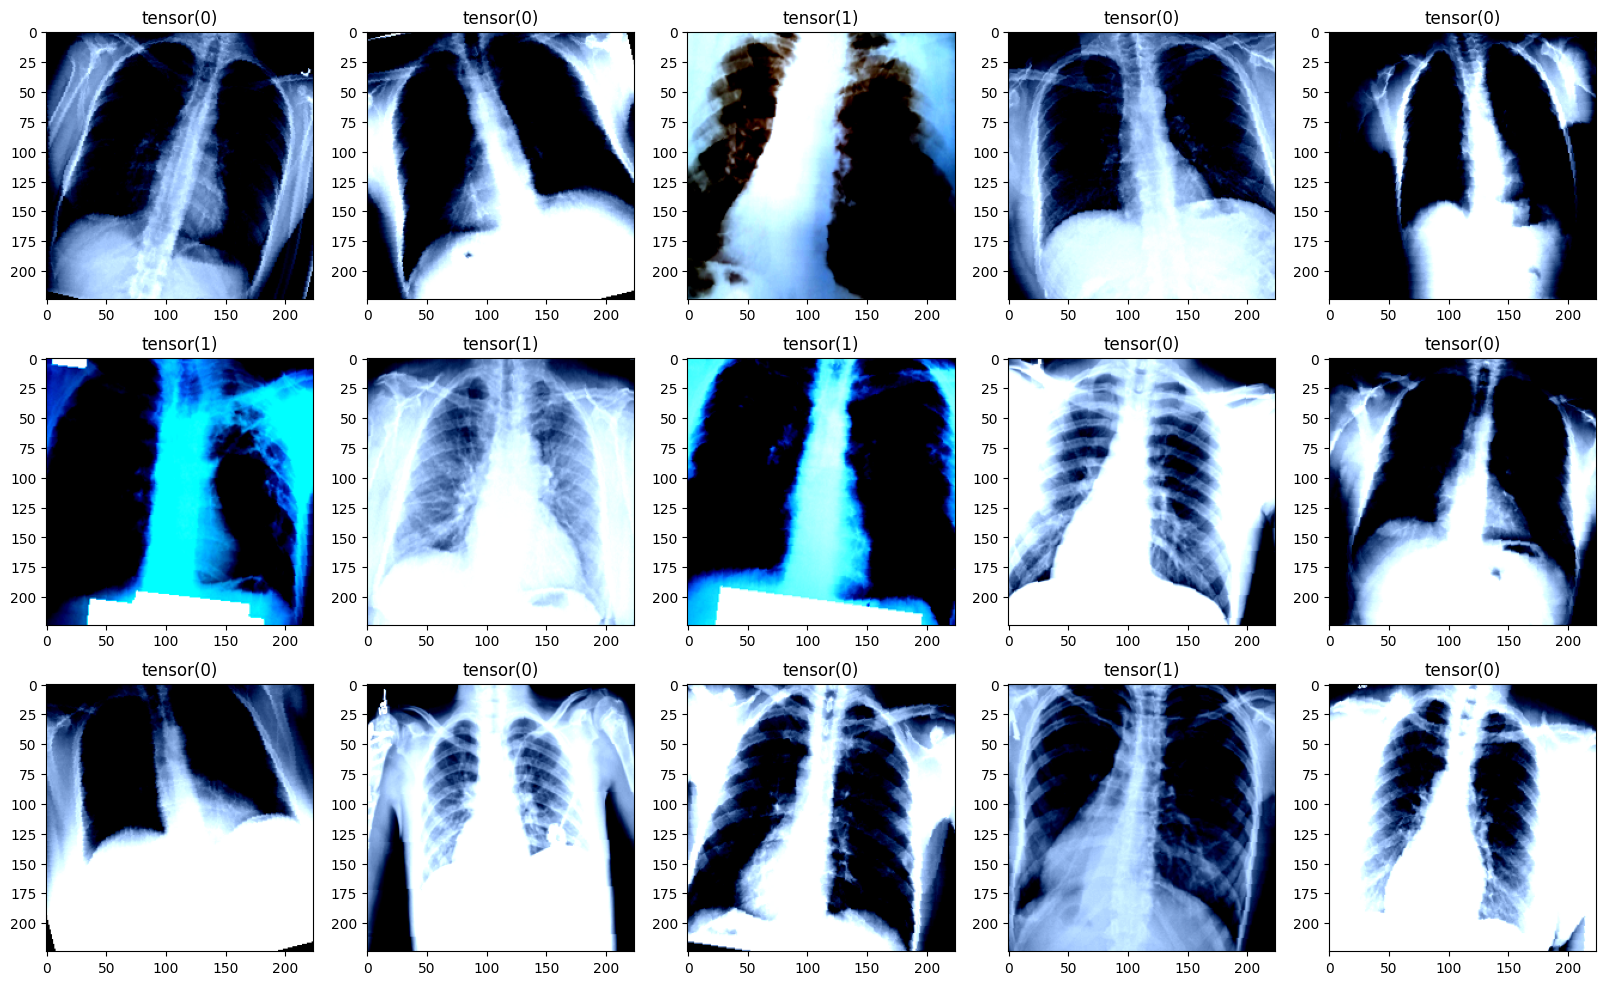

In [ ]:
import matplotlib.pyplot as pplot
data, labels = next(iter(trn_dataloader))
figure, axis = pplot.subplots(3, 5,figsize=(20, 12))
for iterating, axiter in enumerate(axis.flat):
    image, label = data[iterating], labels[iterating]
    image_t = image.numpy().transpose((1, 2, 0))
    image_t = nmpy.clip(image_t, 0, 1)
    axiter.imshow(image_t)
    axiter.set_title(label)
pplot.show()

In [ ]:
from torchvision.models import densenet121,DenseNet121_Weights, DenseNet


class CXR_DenseNetModel(neuraln.Module):
    """DenseNet121 pretrained model"""
    def __init__(self, numc):
        super(CXR_DenseNetModel, self).__init__()
        self.dmodel = torchvision.models.densenet121(pretrained=True)
        for param in self.dmodel.parameters():
            param.requires_grad = False
        in_featrs = self.dmodel.classifier.in_features
        self.dmodel.classifier = neuraln.Sequential(
            neuraln.Linear(in_featrs, in_featrs // 2),
            neuraln.Dropout(0.5),
            neuraln.Linear(in_featrs // 2, in_featrs // 4),
            neuraln.Linear(in_featrs // 4, in_featrs // 8),
            neuraln.Dropout(0.25),
            neuraln.Linear(in_featrs // 8, numc),
        )

    def forward(self, x):
        return self.dmodel(x)

dense_model = CXR_DenseNetModel(numc=2)
dense_model = dense_model.to(devc)

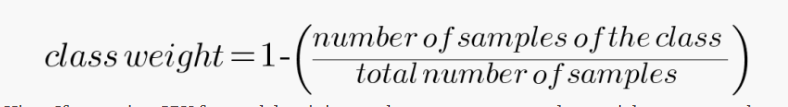

In [ ]:
def cls_wght(x, total):
  return 1 - (x / total)

overall = 2450 + 490
cls_wghts = torch.tensor([cls_wght(2450, overall),cls_wght(490, overall)])

In [ ]:
loss_func = neuraln.BCEWithLogitsLoss(weight=cls_wghts.to(devc))
optim = toptim.Adam(dense_model.parameters(),lr=0.001)

In [ ]:
from tqdm import tqdm as td
t_losses = []
v_losses = []
t_acc = []
v_acc = []

def train(dmodel, loss_func, optim, nepochs):
    for ep in td(range(nepochs)):
        dmodel.train()
        tr_size = 0
        trn_loss = 0.0
        t_accuracy = 0.0
        for btch_idx, (imgs, lbls) in enumerate(trn_dataloader):
            imgs, lbls = imgs.to(devc), lbls.to(devc)
            optim.zero_grad()
            opts = dmodel(imgs)
            lss = loss_func(opts, Func.one_hot(lbls,2).float())
            _, prds = trch.max(opts, 1)
            t_accuracy += trch.sum(prds == lbls.data)
            lss.backward()
            optim.step()
            trn_loss += lss.item() * imgs.size(0)
            tr_size += imgs.size(0)
        dmodel.eval()
        valid_size = 0
        vld_loss = 0.0
        vld_accuracy = 0.0
        for btch_idx, (imgs, lbls) in enumerate(vld_dataloader):
            imgs, lbls = imgs.to(devc), lbls.to(devc)
            optim.zero_grad()
            opts = dmodel(imgs)
            lss = loss_func(opts, Func.one_hot(lbls, 2).float())
            _, prds = trch.max(opts, 1)
            vld_accuracy += trch.sum(prds == lbls.data)
            lss.backward()
            optim.step()
            vld_loss += lss.item() * imgs.size(0)
            valid_size += imgs.size(0)
    trn_loss = trn_loss / tr_size
    t_losses.append(trn_loss)
    t_accuracy = t_accuracy / tr_size
    t_acc.append(t_accuracy)
    vld_loss = vld_loss / valid_size
    v_losses.append(vld_loss)
    vld_accuracy = vld_accuracy / valid_size
    v_acc.append(vld_accuracy)
    print("\nTrain-loss: {trn_loss:.3f}, Train-accuracy: {t_accuracy:.3f}, Valid-loss: {vld_loss:.3f}, Valid-accuracy: {vld_accuracy:.2f}")
train(dense_model, loss_func, optim, 25)


  0%|          | 0/25 [00:37<?, ?it/s]


IsADirectoryError: ignored

## Evaluation

In [ ]:
pplot.plot(t_losses, label='train loss')
pplot.plot(v_losses, label='validation loss')
pplot.legend()
pplot.show()

In [ ]:
train_acc_nmpy = nmpy.array([x.cpu().numpy() for x in t_acc])
valid_acc_nmpy = nmpy.array([x.cpu().numpy() for x in v_acc])
pplot.plot(train_acc_nmpy, label='train accuracy')
pplot.plot(valid_acc_nmpy, label='validation accuracy')
pplot.legend()
pplot.show()


### Test set evaluation

In [ ]:
# TESTING

# 1. Create kaggle key
# 2. Run scripts
# 3. Create 'test' folder
# 4. Put image (512x512 png) in 'test' folder and run this script. (0 - normal, 1 - tuberc)

test_glob = glob.glob("Normal pnem/*")

test_data = TB_CXR_Dataset(test_glob, transform = data_transforms["others"])

test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

model.eval()
for batch_idx, (images, labels) in enumerate(test_dataloader):
            images, labels = images.to(device), labels.to(device)
            #print(labels[0])
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            _, preds = torch.max(outputs, 1)

            print(preds[0].item())
            #break

In [ ]:
# Evaluation on test set
y_true = []
y_hat = []

test_size = 0
test_loss = 0.0
test_accuracy = 0.0
# Loop through the testing dataloader
for batch_idx, (images, labels) in enumerate(test_dataloader):
    images, labels = images.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, F.one_hot(labels,2).float())

    # Compute accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

    y_true.extend(labels.detach().cpu().numpy().tolist())
    y_hat.extend(preds.detach().cpu().numpy().tolist())

    # Backward pass
    loss.backward()
    optimizer.step()

    test_loss += loss.item() * images.size(0)
    test_size += images.size(0)

In [ ]:
import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC, BinaryF1Score
from mlxtend.plotting import plot_confusion_matrix

metrics_acc = BinaryAccuracy()
metric_auroc = BinaryAUROC(thresholds=None)
metric_f1 = BinaryF1Score()

target = torch.tensor(y_true)
preds = torch.tensor(y_hat)

# Accuracy
acc = metrics_acc(preds, target)

# AUROC
auroc = metric_auroc(preds, target)

# F1 Score
f1 = metric_f1(preds, target)

print("Test Accuracy: ", acc)
print("Test AUROC: ", auroc)
print("Test F1: ", f1)

In [ ]:
# Classification Report

from sklearn.metrics import classification_report
target_names = ['normal', 'tuberculosis']
print(classification_report(y_true, y_hat, target_names=target_names))

In [ ]:
from sklearn.metrics import confusion_matrix

# Order of the input parameters is important:
# first param is the actual output values
# second param is what our model predicted
conf_matrix = confusion_matrix(y_true, y_hat)

conf_matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=['normal', 'tuberculosis'])

# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Tuberculosis detection Model')

# show the plot.
# Pass the parameter ax to show customizations (ex. title)
display.plot(ax=ax);

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_true,  y_hat)
auc = metrics.roc_auc_score(y_true, y_hat)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

#Saving and loading model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from pathlib import Path

# create model directory path
MODEL_PATH = Path('/content/drive/MyDrive/TubersavedModel')
MODEL_PATH.mkdir(parents = True,
                 exist_ok = True)

# create model save
MODEL_NAME = '01_tuberculosis_model.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME



# save the entire model
print(f'saving the entire model to :{MODEL_SAVE_PATH}')
torch.save(model, MODEL_SAVE_PATH)

In [ ]:
# loading model
PATH = "/content/drive/MyDrive/TubersavedModel/01_tuberculosis_model.pth"
model = torch.load(PATH,map_location=torch.device('cpu'))

In [ ]:
# saving the model in onnx format
import torch.onnx

 # set the model to inference mode
model.eval()

# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=True)

input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model,
                 x,
                 "/content/drive/MyDrive/TubersavedModel/tuberModel.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("datasets/tuberculosis/Tuberculosis-1.png")

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
img = transform(img)
img = img.unsqueeze_(0)

# Grad CAM visualizaition (Explainable AI)

In [ ]:
# !pip install torchcam

In [ ]:
# !pip install pytorch-gradcam

In [ ]:
# !pip install omnixai[vision]